# Video Deepfake Detection

We use **ResNet + LSTM** as deep learning network to train and validate the real and deepfaked videos.

Preprocessed data
  - [FaceForensics++ Real and fake processed videos](https://drive.google.com/drive/folders/1VIIWRLs6VBXRYKODgeOU7i6votLPPxT0?usp=sharing)
  - [Celeb-DF Fake processed videos](https://drive.google.com/drive/folders/1SxCb_Wr7N4Wsc-uvjUl0i-6PpwYmwN65?usp=sharing)
  - [Celeb-DF Real processed videos](https://drive.google.com/drive/folders/1g97v9JoD3pCKA2TxHe8ZLRe4buX2siCQ?usp=sharing)
  - [DFDC Fake processed videos](https://drive.google.com/drive/folders/1yz3DBeFJvZ_QzWsyY7EwBNm7fx4MiOfF?usp=sharing)
  - [DFDC Real processed videos](https://drive.google.com/drive/folders/1wN3ZOd0WihthEeH__Lmj_ENhoXJN6U)

### 0.Import dependencies

In [1]:
# 0.import dependencies

import glob
import os
import sys
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import torchvision
from torchvision import models
from torchvision import transforms

os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1, 2'

### 1.Check if the file is corrupted or not

In [2]:
# 1.Check if the file is corrupted or not
def validate_video(vid_path, train_transforms):
  transform = train_transforms
  count = 20
  video_path = vid_path
  frames = []
  a = int(100/count)
  first_frame = np.random.randint(0, a)
  temp_video = video_path.split('/')[-1]
  for i, frame in enumerate(frame_extract(video_path)):
    frames.append(transform(frame))
    if(len(frames) == count):
      break
  frames = torch.stack(frames)
  frames = frames[:count]
  return frames

# extract a from from video
def frame_extract(path):
  vidObj = cv2.VideoCapture(path) 
  success = 1
  while success:
      success, image = vidObj.read()
      if success:
          yield image

im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
                                        ])
# - Preprocessed data
#   - [Celeb-DF Fake processed videos](https://drive.google.com/drive/folders/1SxCb_Wr7N4Wsc-uvjUl0i-6PpwYmwN65?usp=sharing)
#   - [Celeb-DF Real processed videos](https://drive.google.com/drive/folders/1g97v9JoD3pCKA2TxHe8ZLRe4buX2siCQ?usp=sharing)
#   - [FaceForensics++ Real and fake processed videos](https://drive.google.com/drive/folders/1VIIWRLs6VBXRYKODgeOU7i6votLPPxT0?usp=sharing)
#   - [DFDC Fake processed videos](https://drive.google.com/drive/folders/1yz3DBeFJvZ_QzWsyY7EwBNm7fx4MiOfF?usp=sharing)
#   - [DFDC Real processed videos](https://drive.google.com/drive/folders/1wN3ZOd0WihthEeH__Lmj_ENhoXJN6U
# video_fil =  glob.glob('fake/*.mp4')
# video_fil +=  glob.glob('real/*.mp4')

video_fil = glob.glob('d:/facedata/FF_Face_only_data/*.mp4') # contained real & fake videos11?usp=sharing)
video_fil = [i.replace('\\', '/') for i in video_fil]
print("Total no of videos :" , len(video_fil))
print(video_fil[:10])

count = 0
for i in video_fil:
  try:
    count+=1
    validate_video(i,train_transforms)
  except:
    print("Number of video processed: " , count ," Remaining: " , (len(video_fil) - count))
    print("Corrupted video is: " , i)
    continue
print(f'Corrupted video: {len(video_fil) - count}')

Total no of videos : 1989
['d:/facedata/FF_Face_only_data/000.mp4', 'd:/facedata/FF_Face_only_data/000_003.mp4', 'd:/facedata/FF_Face_only_data/001.mp4', 'd:/facedata/FF_Face_only_data/001_870.mp4', 'd:/facedata/FF_Face_only_data/002.mp4', 'd:/facedata/FF_Face_only_data/002_006.mp4', 'd:/facedata/FF_Face_only_data/003.mp4', 'd:/facedata/FF_Face_only_data/003_000.mp4', 'd:/facedata/FF_Face_only_data/004.mp4', 'd:/facedata/FF_Face_only_data/004_982.mp4']
Corrupted video: 0


### 2.Load preprocessod video to memory

In [3]:
# 2.Load preprocessod video to memory

# video_fil =  glob.glob('fake/*.mp4')
# video_fil +=  glob.glob('real/*.mp4')
video_files = glob.glob('d:/facedata/FF_Face_only_data/*.mp4') 
video_files = [i.replace('\\', '/') for i in video_files]
print("Total no of original video: " , len(video_files))
random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
video_files_copy = video_files[:]
for video_file in video_files_copy:
  cap = cv2.VideoCapture(video_file)
  fc = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  if(fc < 100):
    video_files.remove(video_file) # if the frames number of one video < 100, remove it, 3431 - 39 = 3392
    continue
  frame_count.append(fc)
print("video_files are ", video_files[:10])
print("frames are ", frame_count[:10])
print("Total no of video: ", len(frame_count), len(video_files))
print('Average frame per video:', np.mean(frame_count))

Total no of original video:  1989
video_files are  ['d:/facedata/FF_Face_only_data/447_431.mp4', 'd:/facedata/FF_Face_only_data/960.mp4', 'd:/facedata/FF_Face_only_data/699_734.mp4', 'd:/facedata/FF_Face_only_data/285_136.mp4', 'd:/facedata/FF_Face_only_data/114_102.mp4', 'd:/facedata/FF_Face_only_data/169.mp4', 'd:/facedata/FF_Face_only_data/605_591.mp4', 'd:/facedata/FF_Face_only_data/746_571.mp4', 'd:/facedata/FF_Face_only_data/607_683.mp4', 'd:/facedata/FF_Face_only_data/012.mp4']
frames are  [148, 148, 148, 148, 148, 148, 148, 148, 148, 148]
Total no of video:  1987 1987
Average frame per video: 148.0


### 3.Define video_dataset, load the video name and labels from csv

In [4]:
# 3.Define video_dataset, load the video name and labels from csv

class video_dataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        # print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]), 1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i, frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        # print("length:" , len(frames), "label",label)
        return frames, label

    def frame_extract(self, path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image

### 4.Define some functions to plot and count numbers of real/fake images

In [5]:
# 4.Define some functions
# plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()
    
    
# count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake += 1
    if(label == 'REAL'):
      real += 1
  return real, fake

### 5.Load the videos & labels into dataloader

train :  1589
test :  398
TRAIN:  Real: 803  Fake: 786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TEST:  Real: 189  Fake: 209
len(train_loader):  397  len(valid_loader):  99


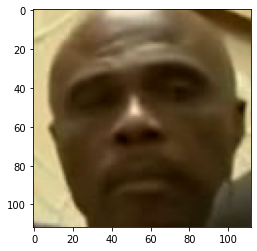

In [6]:
# 5.Load the labels and video in data loader

header_list = ["file","label"]
labels = pd.read_csv('Gobal_metadata.csv',names=header_list)

train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]

print("train : " , len(train_videos))
print("test : " , len(valid_videos))

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])

im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
                                        ])
train_data = video_dataset(train_videos, labels, sequence_length=10, transform=train_transforms)
val_data = video_dataset(valid_videos, labels, sequence_length=10, transform=test_transforms)
train_loader = DataLoader(dataset=train_data, batch_size=4, shuffle=True, num_workers=0, drop_last=True)
valid_loader = DataLoader(dataset=val_data, batch_size=4, shuffle=True, num_workers=0, drop_last=True)

print('len(train_loader): ', len(train_loader), ' len(valid_loader): ', len(valid_loader))
image, label = train_data[0]
im_plot(image[0,:,:,:])

### 6.Define Model with CNN + LSTM

In [7]:
# 6.Define Model with feature visualization

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1 , hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.linear1 = nn.Linear(2048, num_classes)
        self.dp = nn.Dropout(0.4)
        
    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(torch.mean(x_lstm, dim = 1)))

### 7.Use Model then print it

In [8]:
# 7.Use Model

model = nn.DataParallel(Model(2)).cuda()
# model = Model(2).cuda()
a, b = model(torch.from_numpy(np.empty((4,20,3,112,112))).type(torch.cuda.FloatTensor))
print(next(model.parameters()).device)
print(model)
print(a, b)

c:\Users\siat\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


cuda:0
DataParallel(
  (module): Model(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

### 8.Define the train & test procession

In [9]:
# 8.Define the train & test procession

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

        
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size


def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    print('\nTraining')
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        # print(i)
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i+1,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'checkpoint.pt')
    return losses.avg, accuracies.avg
    

def test(epoch, model, data_loader ,criterion):
    print('\nTesting')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i+1,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {} %'.format(accuracies.avg))
    return true, pred, losses.avg, accuracies.avg

### 9.Define some functions to plot train&validate loss, acc, confusion matrix

In [10]:
# 9.Define some functions

# Plot train & valid loss curve
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  # print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


# Plot train & valid accuracy curve
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


# Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    # print("Calculated Accuracy", calculated_acc*100, '%')

### 10.Train & validate the network


Training


c:\Users\siat\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


[Epoch 1/20] [Batch 397 / 397] [Loss: 0.664535, Acc: 58.25%]
Testing
[Batch 99 / 99]  [Loss: 0.495809, Acc: 77.78%]
Accuracy 77.77777777777777 %

Training
[Epoch 2/20] [Batch 397 / 397] [Loss: 0.580121, Acc: 70.78%]
Testing
[Batch 99 / 99]  [Loss: 0.429877, Acc: 82.83%]
Accuracy 82.82828282828282 %

Training
[Epoch 3/20] [Batch 397 / 397] [Loss: 0.564626, Acc: 72.17%]
Testing
[Batch 99 / 99]  [Loss: 0.391622, Acc: 84.85%]
Accuracy 84.84848484848484 %

Training
[Epoch 4/20] [Batch 397 / 397] [Loss: 0.548298, Acc: 73.24%]
Testing
[Batch 99 / 99]  [Loss: 0.318135, Acc: 86.11%]
Accuracy 86.11111111111111 %

Training
[Epoch 5/20] [Batch 397 / 397] [Loss: 0.503691, Acc: 76.26%]
Testing
[Batch 99 / 99]  [Loss: 0.323931, Acc: 85.10%]
Accuracy 85.1010101010101 %

Training
[Epoch 6/20] [Batch 397 / 397] [Loss: 0.472223, Acc: 79.53%]
Testing
[Batch 99 / 99]  [Loss: 0.282682, Acc: 89.65%]
Accuracy 89.64646464646465 %

Training
[Epoch 7/20] [Batch 397 / 397] [Loss: 0.405582, Acc: 84.95%]
Testing
[B

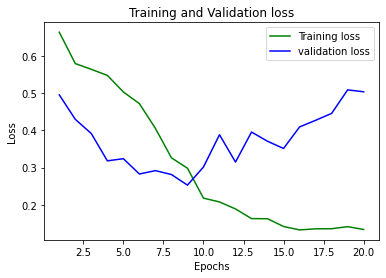

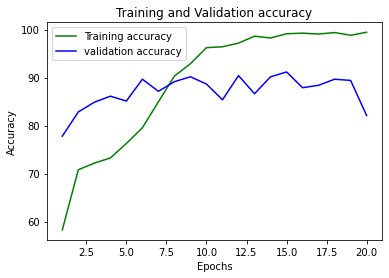

[[180  28]
 [ 43 145]]
True positive =  180
False positive =  28
False negative =  43
True negative =  145




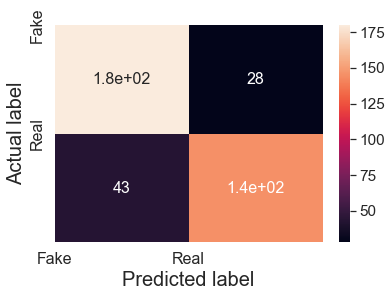

In [11]:
# 10.Train & validate

# learning rate
lr = 1e-5
# number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
# criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []

for epoch in range(1, num_epochs+1):
    l, acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    
    true, pred, tl, t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

plot_loss(train_loss_avg, test_loss_avg, len(train_loss_avg))
plot_accuracy(train_accuracy, test_accuracy, len(train_accuracy))
print(confusion_matrix(true, pred))
print_confusion_matrix(true, pred)